In [1]:
# Import all necessary packages

using DifferentialEquations #To define and simulate the model
using PyPlot #To plot the results (also Plots.jl can be used or othe plotting packages such as plotly)
using LaTeXStrings #To use latex in plots

In [2]:
# Model of differential equations compatible with DifferentialEquations.jl
function SEIR_v!(du, u, p, t)
    
    S, E, I, R, Sv, Iv = u #functions
    
    β, κ, γ, α, μ, N = p #parameters
    
    #Differential equations defining the model
    du[1] = dS = -β*S*Iv/N
    du[2] = dE = β*S*Iv/N - κ*E
    du[3] = dI = κ*E - γ*I
    du[4] = dR = γ*I
    
    du[5] = dSv = -α*Sv*I/N - μ*Sv
    du[6] = dIv = α*Sv*I/N - μ*Iv
    
end

# Basic reproductive number
function R_0(β, α, κ, γ, μ, N, Nv, S0, τ)
   
    return  β*α/ (γ*μ) * (S0/N^2) * (Nv/(μ*τ)) * (1-exp(-μ*τ))
    
end

# Auxiliar function to easily obtain the model results
function get_vars(sol)
   
    S = []
    E = []
    I = []
    R = []
    
    S_V = []
    I_V = []
    
    for item in sol.u
       
        append!(S, item[1])
        append!(E, item[2])
        append!(I, item[3])
        append!(R, item[4])
        
        append!(S_V, item[5])
        append!(I_V, item[6])
        
    end
    
    return S, E, I, R, S_V, I_V
    
end

get_vars (generic function with 1 method)

In [3]:
#Parameters (defined as daily rates)
α = 0.086
β = 0.02
κ = (1/4.47) / 365
γ = (1/13.82) / (365)
μ = 0.022
δ = 0.0

#Initial conditions
N = 10^3
Nv = 0.5 * N

E0 = 0
I0 = 0.01 * N
S0 = N - I0
R0 = 0

Sv0 = Nv
Iv0 = 0

#Simulation time
N_years = 35
t = 365 * N_years

#Integrate parameters and initial conditions to use within DifferentialEquations.jl
initial_conditions = [S0, E0, I0, R0, Sv0, Iv0]

parameters = [β, κ, γ, α, μ, N]

time = (0.0, t)

#Define the source term δ(t-t*)N_v(0)

affect!(integrator) = integrator.u[5] = Nv #Select to which differential equation the source term will apply
dosetimes = [365.0 * i for i in 1 : N_years]  #Select when the source term will aply

cb = PresetTimeCallback(dosetimes, affect!) #Define the source term

prob = ODEProblem(SEIR_v!, initial_conditions, time, parameters) #Define problem in DifferentialEquations.jl

sol = solve(prob, RK4(), adaptative=false, dt=5e-2, saveat=1, callback=cb) #Solve the problem

t = sol.t / 365.0 #time in years

S, E, I, R, Sv, Iv = get_vars(sol); #Obtain results for the evolution of the variables

#Compute R0(t)
τ = 365.0

R0s = [R_0(β, α, κ, γ, μ, N, Nv, S0, τ) for S0 in S];

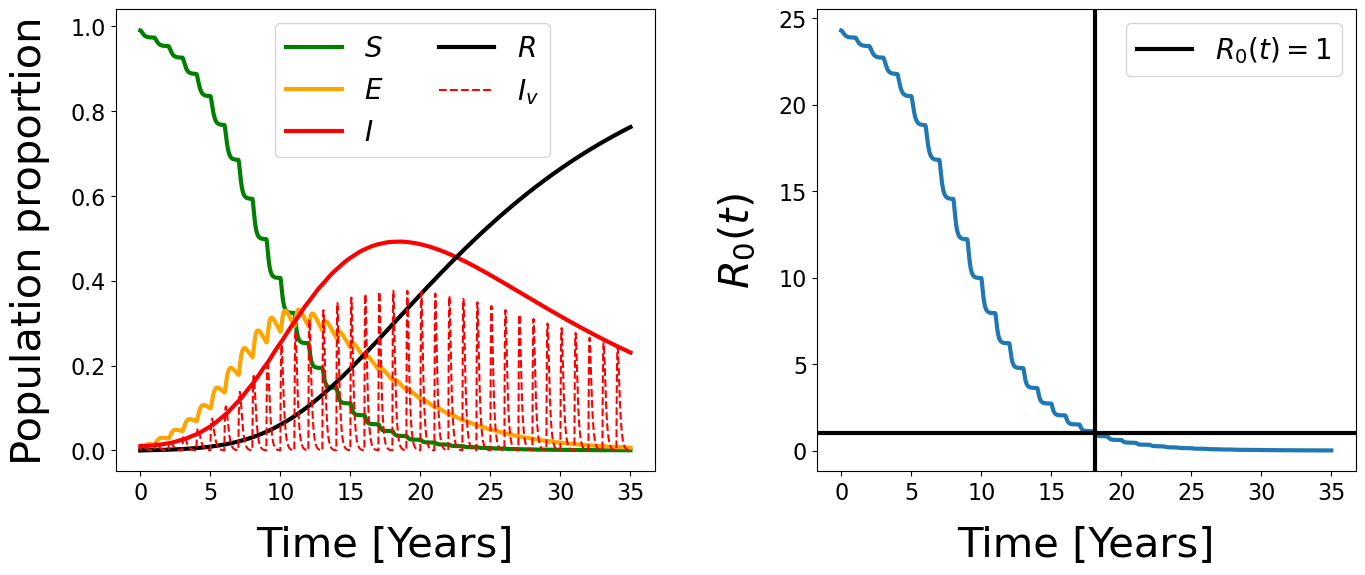

In [4]:
#Plot the results

fig, ax = plt.subplot_mosaic("""AB""", figsize=(8*2, 6))

ax["A"].plot(t, S/N, lw=3, color="g", label=L"S")
ax["A"].plot(t, E/N, lw=3, color="orange", label=L"E")
ax["A"].plot(t, I/N, lw=3, color="r", label=L"I")
ax["A"].plot(t, R/N, lw=3, color="black", label=L"R")

ax["A"].plot(t, Iv / Nv, ls="--", color="r", label=L"I_v")


ax["A"].tick_params("both", labelsize=16)

ax["A"].set_xlabel("Time [Years]", fontsize=30, labelpad=15)
ax["A"].set_ylabel("Population proportion", fontsize=30, labelpad=15)

ax["A"].legend(ncol=2, fontsize=20, loc="upper center", bbox_to_anchor=(0.55, 1))

ax["B"].plot(t, R0s, lw=3)
ax["B"].axvline(t[R0s .< 1][1], color="k", lw=3, label=L"R_0(t)=1")
ax["B"].axhline([1], color="k", lw=3)

ax["B"].tick_params("both", labelsize=16)

ax["B"].set_xlabel("Time [Years]", fontsize=30, labelpad=15)
ax["B"].set_ylabel(L"R_0(t)", fontsize=30, labelpad=15)

ax["B"].legend(fontsize=20)

plt.subplots_adjust(wspace=0.3)